In [1]:
# !IMPORTANT - to run this notebook download dataset from https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis and put it in same folder as for this notebook
# then import wiki-news-300d-1M.vec from https://www.kaggle.com/datasets/facebook/fasttext-wikinews

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from keras import layers, models, optimizers
from sklearn import ensemble
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from keras.preprocessing import text, sequence
from keras.utils import pad_sequences
from textblob import TextBlob
from textblob import Word
nltk.download('stopwords')
from nltk.corpus import stopwords

# Set column name
column_names = ['reviewer_id','game','emotion','review']  

# Import .csv data into DataFrame
tweetsDF = pd.read_csv('twitter_training.csv', names=column_names)

tweetsDF.head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lubie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,reviewer_id,game,emotion,review
0,reviewer_id,game,emotion,review
1,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
2,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
3,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
4,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
5,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
6,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
7,2402,Borderlands,Positive,So I spent a few hours making something for fu...
8,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
9,2402,Borderlands,Positive,So I spent a few hours doing something for fun...


In [3]:
len(tweetsDF)

74683

In [1]:
%pwd

'C:\\Users\\lubie\\data'

In [4]:
# Remove rows with empty or whitespace-only 'review' entries
tweetsDF.replace(r'^\s*$', np.nan, regex=True, inplace=True)
tweetsDF.dropna(subset=['review'], thresh=1, inplace=True)

# Drop rows where 'emotion' is "Irrelevant"
tweetsDF = tweetsDF[tweetsDF['emotion'] != 'Irrelevant']

tweets = tweetsDF.copy()

len(tweets)

60983

In [5]:
emotions = pd.get_dummies(tweets['emotion'])
emotions.head()

,Negative,Neutral,Positive,emotion
0,False,False,False,True
1,False,False,True,False
2,False,False,True,False
3,False,False,True,False
4,False,False,True,False


In [6]:
# analyze dataset
# check number of words in each review
tweets['word_count'] = tweets['review'].apply(lambda x: len(str(x).split(" ")))
print(tweets[['review','word_count']].head())
print(tweets['word_count'].max())
print(tweets['word_count'].min())
print(tweets['word_count'].mean())

                                              review  word_count
0                                             review           1
1  im getting on borderlands and i will murder yo...          11
2  I am coming to the borders and I will kill you...          12
3  im getting on borderlands and i will kill you ...          10
4  im coming on borderlands and i will murder you...          10
198
1
19.356656773199088


In [7]:
# check character number
def char_count(df):
    df['char_count'] = df['review'].apply(lambda x: len(str(x)))
    return df

tweets = char_count(tweets)
print(tweets[['review', 'char_count']].head())
print(tweets['char_count'].max())
print(tweets['char_count'].min())
print(tweets['char_count'].mean())

                                              review  char_count
0                                             review           6
1  im getting on borderlands and i will murder yo...          53
2  I am coming to the borders and I will kill you...          51
3  im getting on borderlands and i will kill you ...          50
4  im coming on borderlands and i will murder you...          51
957
1
108.57460275814572


In [8]:
# check average word length

def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

tweets['avg_word'] = tweets['review'].apply(lambda x: avg_word(x))
tweets[['review','avg_word']].head()

,review,avg_word
0,review,6.000000
1,im getting on borderlands and i will murder yo...,3.909091
2,I am coming to the borders and I will kill you...,3.333333
3,im getting on borderlands and i will kill you ...,4.100000
4,im coming on borderlands and i will murder you...,4.200000


In [9]:
# check number of stop-words (stop-words are common words not important for analysis)

stop = stopwords.words('english')

tweets['stopwords'] = tweets['review'].apply(lambda x: len([x for x in x.split() if x in stop]))
print(tweets[['review','stopwords']].head())
print(tweets['stopwords'].max())
print(tweets['stopwords'].min())
print(tweets['stopwords'].mean())

                                              review  stopwords
0                                             review          0
1  im getting on borderlands and i will murder yo...          6
2  I am coming to the borders and I will kill you...          6
3  im getting on borderlands and i will kill you ...          5
4  im coming on borderlands and i will murder you...          5
40
0
5.94226259777315


In [10]:
# check numeric characters number
tweets['numerics'] = tweets['review'].apply(lambda x: len([x for x in x.split(' ') if x.isnumeric()]))
print(tweets[['review','numerics']].head())
print(tweets['numerics'].max())
print(tweets['numerics'].min())
print(tweets['numerics'].mean())

                                              review  numerics
0                                             review         0
1  im getting on borderlands and i will murder yo...         0
2  I am coming to the borders and I will kill you...         0
3  im getting on borderlands and i will kill you ...         0
4  im coming on borderlands and i will murder you...         0
14
0
0.28990046406375547


In [11]:
# check number of upper case letters
tweets['upper'] = tweets['review'].apply(lambda x: len([word for word in x.split() if word.isupper()]))
print(tweets[['review', 'upper']].head())
print(tweets['upper'].max())
print(tweets['upper'].min())
print(tweets['upper'].mean())

                                              review  upper
0                                             review      0
1  im getting on borderlands and i will murder yo...      0
2  I am coming to the borders and I will kill you...      2
3  im getting on borderlands and i will kill you ...      0
4  im coming on borderlands and i will murder you...      0
166
0
1.1650623944377942


In [12]:
# check number of capital words
tweets['capital'] = tweets['review'].apply(lambda x: len([word for word in x.split(' ') if word and word[0].isupper()]))
print(tweets[['review', 'capital']].head())
print(tweets['capital'].max())
print(tweets['capital'].min())
print(tweets['capital'].mean())

                                              review  capital
0                                             review        0
1  im getting on borderlands and i will murder yo...        0
2  I am coming to the borders and I will kill you...        2
3  im getting on borderlands and i will kill you ...        0
4  im coming on borderlands and i will murder you...        0
166
0
3.969745666825181


In [13]:
# check number of punctuation characters
tweets['punctuation'] = tweets['review'].apply(lambda x: len(re.findall(r'[\.,?!;:]', x)))
print(tweets[['review', 'punctuation']].head())
print(tweets['punctuation'].max())
print(tweets['punctuation'].min())
print(tweets['punctuation'].mean())

                                              review  punctuation
0                                             review            0
1  im getting on borderlands and i will murder yo...            1
2  I am coming to the borders and I will kill you...            1
3  im getting on borderlands and i will kill you ...            1
4  im coming on borderlands and i will murder you...            1
304
0
3.51830838102422


In [14]:
# normalize text
# apply lowercase
def normalize_text(df):
    df['review'] = df['review'].apply(lambda x: " ".join(x.lower() for x in str(x).split()) if pd.notnull(x) else "")
    return df

tweetsDFRaw = tweetsDF.copy()
tweetsDF = normalize_text(tweetsDF)
tweetsDF['review'].head()

0                                               review
1    im getting on borderlands and i will murder yo...
2    i am coming to the borders and i will kill you...
3    im getting on borderlands and i will kill you ...
4    im coming on borderlands and i will murder you...
Name: review, dtype: object

In [15]:
# remove special characters
tweetsDF['review'] = tweetsDF['review'].str.replace('[^\w\s]','')
tweetsDF['review'].head()

0                                               review
1    im getting on borderlands and i will murder yo...
2    i am coming to the borders and i will kill you...
3    im getting on borderlands and i will kill you ...
4    im coming on borderlands and i will murder you...
Name: review, dtype: object

In [16]:
# remove "stopwords"
stop = stopwords.words('english')
tweetsDF['review'] = tweetsDF['review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
tweetsDF['review'].head()

0                               review
1      im getting borderlands murder ,
2             coming borders kill all,
3     im getting borderlands kill all,
4    im coming borderlands murder all,
Name: review, dtype: object

In [17]:
# prepare list of most frequent words
freq = pd.Series(' '.join(tweetsDF['review']).split()).value_counts()[:20]
freq

/          12113
@           9397
.           7824
game        5645
-           3989
like        3672
get         3408
&           2799
new         2750
play        2745
2           2657
really      2643
one         2633
johnson     2623
i'm         2578
good        2424
love        2374
still       2116
_           2035
’           1999
Name: count, dtype: int64

In [18]:
# remove most frequent words
freq = list(freq.index)
tweetsDF['review'] = tweetsDF['review'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
tweetsDF['review'].head()

0                               review
1      im getting borderlands murder ,
2             coming borders kill all,
3     im getting borderlands kill all,
4    im coming borderlands murder all,
Name: review, dtype: object

In [19]:
# prepare list of rare words
freq = pd.Series(' '.join(tweetsDF['review']).split()).value_counts()[-20:]
freq

hearthstone-de...               1
theg.com                        1
qjyss1pn4n                      1
hearthstone-en...               1
thegamer.com                    1
thegamer.com/hearthstone-de…    1
shindanmaker.                   1
winrate..                       1
dgonsssssss                     1
theme)                          1
bass!                           1
vargott.                        1
rebuild)                        1
profile<unk>                    1
flexible                        1
one-offs                        1
winrate...                      1
(wild).                         1
best..                          1
experiments.                    1
Name: count, dtype: int64

In [20]:
# remove rare words
freq = list(freq.index)
tweetsDF['review'] = tweetsDF['review'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
tweetsDF['review'].head()

0                               review
1      im getting borderlands murder ,
2             coming borders kill all,
3     im getting borderlands kill all,
4    im coming borderlands murder all,
Name: review, dtype: object

In [21]:
# fix typos
from textblob import TextBlob
tweetsDF['review'][:5].apply(lambda x: str(TextBlob(x).correct()))

0                               review
1      in getting borderlands murder ,
2             coming borders kill all,
3     in getting borderlands kill all,
4    in coming borderlands murder all,
Name: review, dtype: object

In [22]:
#lemmatize - unify words with same language core
from textblob import Word
nltk.download('wordnet')

tweetsDF = tweetsDF.copy()
tweetsDF['review'] = tweetsDF['review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
tweetsDF['review'].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lubie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0                              review
1      im getting borderland murder ,
2             coming border kill all,
3     im getting borderland kill all,
4    im coming borderland murder all,
Name: review, dtype: object

In [23]:
# prepare model
# split data to train and test set
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(tweetsDF['review'], tweetsDF['emotion'])

# encode categorical values
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

print(valid_y)

[0 1 1 ... 2 2 1]


In [24]:
# encode text to TF-IDF numeric vectors

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(tweetsDF['review'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

In [25]:
# universal method for model training

def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # train model
    classifier.fit(feature_vector_train,  train_y)
    
    # generate predictions for test set
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    # evaluate model
    scores = list(metrics.precision_recall_fscore_support(predictions, valid_y))
    score_vals = [
        scores[0][0],
        scores[1][0],
        scores[2][0]
    ]
    score_vals.append(metrics.accuracy_score(predictions, valid_y))
    return score_vals

In [26]:
# MODEL 1 - Logistic Regression (One-vs-Rest)
model_lr = linear_model.LogisticRegression(multi_class='ovr', max_iter=1000)
accuracy = train_model(model_lr, xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compare = {'LR': accuracy}
print("LR, WordLevel TF-IDF: ", accuracy)

LR, WordLevel TF-IDF:  [0.8118668596237337, 0.7627464309993202, 0.786540483701367, 0.7445887445887446]


C:\Users\lubie\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# MODEL 2 - Support Vector Machine

accuracy = train_model(svm.SVC(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compare['SVM'] = accuracy
print ("SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  [0.9214905933429812, 0.9280378939697577, 0.9247526549877463, 0.9132887314705497]


C:\Users\lubie\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
# MODEL 3 - Random Forest Tree 
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compare['RF'] = accuracy
print ("RF, WordLevel TF-IDF: ", accuracy)

RF, WordLevel TF-IDF:  [0.9122648335745297, 0.9180775532495904, 0.9151619635241811, 0.9046963137872229]


C:\Users\lubie\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# coding words as vectors with encoded meaning - word embeddings

from keras.preprocessing import text, sequence
from keras.utils import pad_sequences

embeddings_index = {}
with open('wiki-news-300d-1M.vec', encoding='utf-8') as file:
    for i, line in enumerate(file):
        try:
            values = line.split()
            embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
        except UnicodeDecodeError:
            print(f"UnicodeDecodeError in line {i + 1}: {line}")
            # Handle the error or skip problematic lines


# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(tweetsDF['review'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [30]:
# MODEL 4 - convolutional neural network with word embeddings

def create_cnn():
    # add input layer
    input_layer = layers.Input((70, ))

    # add encoding layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # add convolutional layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # add connection layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # add aoutput layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # compile model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_cnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
accuracy_compare['CNN'] = accuracy
print ("CNN, Word Embeddings",  accuracy)



477/477 [==============================] - 2s 4ms/step
CNN, Word Embeddings [1.0, 0.3625869080414535, 0.5322037161836912, 0.3625869080414535]


C:\Users\lubie\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

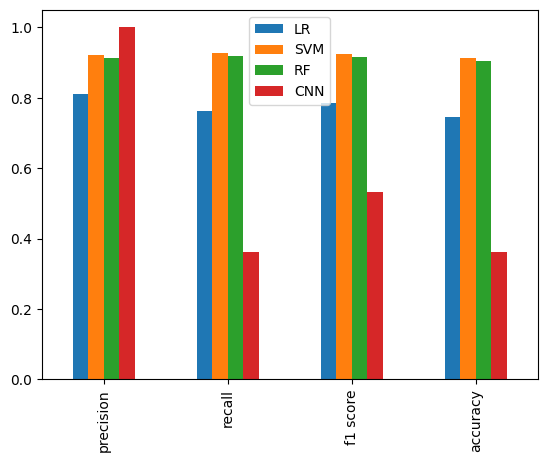

In [31]:
# evaluate models
# compare models

df_compare = pd.DataFrame(accuracy_compare, index = ['precision', 'recall', 'f1 score', 'accuracy'])
df_compare.plot(kind='bar')

<Axes: >

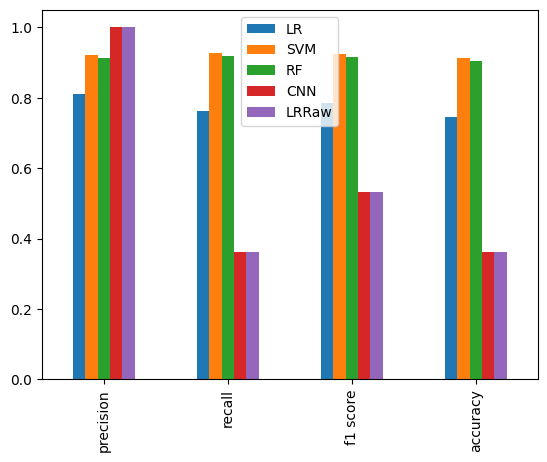

In [32]:
# without text normalization

# split to train and test set
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(tweetsDFRaw['review'], tweetsDFRaw['emotion'])

# Handle NaN values
train_x = train_x.fillna('')
valid_x = valid_x.fillna('')

# encode to numeric vectors
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

# encode as TF-IDF

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(tweetsDF['review'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# MODEL 1 - logistic regression
accuracy_compare['LRRaw'] = accuracy
accuracy = train_model(linear_model.LogisticRegression(max_iter=10000), xtrain_tfidf, train_y, xvalid_tfidf)

df_compare = pd.DataFrame(accuracy_compare, index = ['precision', 'recall', 'f1 score', 'accuracy'])
df_compare.plot(kind='bar')

In [33]:
import unittest
class TestCharacterCount(unittest.TestCase):
    
    def setUp(self):
        # Przygotowanie danych do testów
        self.input_data = pd.DataFrame({'review': ['test', 'teeeeeest']})
        self.expected_output = pd.DataFrame({'review': ['test', 'teeeeeest'], 'char_count': [4, 9]})
    
    def test_char_count_text(self):
        # Wywołanie funkcji na przygotowanych danych
        result = char_count(self.input_data.copy())
        
        # Sprawdzenie czy wynik jest zgodny z oczekiwaniami
        pd.testing.assert_frame_equal(result, self.expected_output)


class TestNormalizeText(unittest.TestCase):
    
    def setUp(self):
        # Przygotowanie danych do testów
        self.input_data = pd.DataFrame({'review': ['Hello World', '  UPPer CaSE ']})
        self.expected_output = pd.DataFrame({'review': ['hello world', 'upper case']})
    
    def test_normalize_text(self):
        # Wywołanie funkcji na przygotowanych danych
        result = normalize_text(self.input_data.copy())
        
        # Sprawdzenie czy wynik jest zgodny z oczekiwaniami
        pd.testing.assert_frame_equal(result, self.expected_output)

all_tests = unittest.TestSuite()
all_tests.addTest(unittest.TestLoader().loadTestsFromTestCase(TestNormalizeText))
all_tests.addTest(unittest.TestLoader().loadTestsFromTestCase(TestCharacterCount))

unittest.TextTestRunner().run(all_tests)

..
----------------------------------------------------------------------
Ran 2 tests in 0.004s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>